# Imports:

In [10]:
import torch
import numpy as np
import pandas as pd
import seaborn as sn
import json
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (20, 8)

# Definition of functions:

In [11]:
# search for columns_selection
def determine_columns_sel(dataset_name):

    # initialize columns_sel as list
    columns_sel = []
    if dataset_name == 'sepsis_cases_1':
            columns_sel = ['Diagnose', 'mean_open_cases', 'Age', 'std_Leucocytes', 'std_CRP']#sepsis_cases_1
    elif dataset_name == 'sepsis_cases_2':
            columns_sel = ['Diagnose', 'mean_open_cases', 'mean_hour', 'DisfuncOrg']#sepsis_cases_2
    elif dataset_name == 'sepsis_cases_4':
            columns_sel = ['Diagnose', 'mean_open_cases', 'Age', 'org:group_E', 'std_CRP', 'DiagnosticECG']#sepsis_cases_4
    elif dataset_name == 'bpic2011_f1':
            columns_sel = ['Diagnosis Treatment Combination ID', 'mean_open_cases', 'Diagnosis', 'Activity code_376400.0']#bpic2011_f1
    elif dataset_name == 'bpic2011_f2':
            columns_sel = ['Diagnosis Treatment Combination ID', 'Diagnosis', 'Diagnosis code', 'mean_open_cases', 'Activity code_376400.0', 'Age', 'Producer code_CHE1']#bpic2011_f2
    elif dataset_name == 'bpic2011_f3':
            columns_sel = ['Diagnosis Treatment Combination ID', 'Diagnosis', 'mean_open_cases', 'Diagnosis code', 'std_event_nr', 'mean_event_nr']#bpic2011_f3
    elif dataset_name == 'bpic2011_f4':
            columns_sel = ['Diagnosis Treatment Combination ID', 'Treatment code']#bpic2011_f4
    elif dataset_name == 'bpic2012_accepted':
            columns_sel = ['AMOUNT_REQ', 'Activity_O_SENT_BACK-COMPLETE', 'Activity_W_Valideren aanvraag-SCHEDULE', 'Activity_W_Valideren aanvraag-START']#bpic2012_accepted
    elif dataset_name == 'bpic2012_declined':
            columns_sel = ['AMOUNT_REQ', 'Activity_A_PARTLYSUBMITTED-COMPLETE', 'Activity_A_PREACCEPTED-COMPLETE', 'Activity_A_DECLINED-COMPLETE', 'Activity_W_Completeren aanvraag-SCHEDULE', 'mean_open_cases'] #bpic2012_declined
    elif dataset_name == 'bpic2012_cancelled':
            columns_sel = ['Activity_O_SENT_BACK-COMPLETE', 'Activity_W_Valideren aanvraag-SCHEDULE', 'Activity_W_Valideren aanvraag-START', 'AMOUNT_REQ', 'Activity_W_Valideren aanvraag-COMPLETE', 'Activity_A_CANCELLED-COMPLETE']#bpic2012_cancelled
    elif dataset_name == 'production':
            columns_sel = ['Work_Order_Qty', 'Activity_Turning & Milling - Machine 4', 'Resource_ID0998', 'Resource_ID4794', 'Resource.1_Machine 4 - Turning & Milling']#production
    return columns_sel

In [12]:
# collection of model and evaluation with test-set
def creation_and_prediction(dataset_name, columns_sel):

    # create model from train_anfis.py
    model = torch.load('models_lj/model_' + dataset_name + '.h5')
    # read in data from the test-set and separate into features and classification
    df_test = pd.read_csv("dataset/" + dataset_name + "/" + dataset_name + '_test.csv', header=0, sep=',')
    df_features = df_test[columns_sel]
    df_targets = df_test[['Classification']]
    # create torch array from features
    conv_test = torch.tensor(df_features.values, dtype=torch.float)
    # enable evaluation mode
    model.eval()
    with torch.no_grad():
        # predict outcome of each feature vector and split into prediction and certainty
        pred = model(torch.Tensor(conv_test))
        pred = torch.max(pred, 1)
    # we can call the outcome of the model: certainty since it is a summation of gaussian outcomes. This is why this NN is also refered to s XAI... certainty is already part of the outcome.
    df_targets = df_targets.assign(model_classification = pred.indices.detach().numpy(), model_certainty = pred.values.detach().numpy())
    return df_features, df_targets

In [13]:
# creation of certainty-histograms with 50 bins. Distinguishment between false and correct cases
def histplot_model_certainty(df_features, df_targets, dataset_name):

    # check if classification of model is similar to the true classification of the feature vector
    false_class_df = df_features.loc[df_targets['Classification'] != df_targets['model_classification']]
    false_class_df['model_certainty'] = df_targets['model_certainty'].iloc[false_class_df.index]
    # create histogram for analysis purposes
    histplot_binning = np.linspace(0, df_targets['model_certainty'].max(), 50)
    # create visualization
    fig, axs = plt.subplots(1,1)
    sn.histplot(data=df_targets, x='model_certainty', bins=histplot_binning, color='b', label='all')
    sn.histplot(data=false_class_df, x='model_certainty', bins=histplot_binning, color='r', label='false')
    axs.set_title(f'Model certainty comparison of all and false classifications of the test-set of {dataset_name}', fontsize=20)
    axs.legend(fontsize=15)
    axs.set_xlabel('model_certainty', fontsize=15)
    axs.set_ylabel('Count', fontsize=15)
    axs.tick_params(labelsize=12)
    #plt.savefig('results/further_analysis/results/further_analysis/comparison_certainty_histogram_correct_false/'+dataset_name+'_hist-certainty.png')
    plt.show()

In [14]:
# binning of ids that were assigned faulty corresponding to their prediction certainty
def binning_of_ids(df_targets, bins_numb=10):

    # assign bin labels to predictions that were faulty. I.e. you can understand the bin labels as level of falseness.
    false_class_df = df_targets.loc[df_targets['Classification'] != df_targets['model_classification']]
    max = false_class_df['model_certainty'].max() # maximal model_certainty as bound
    bins = np.linspace(0, max, bins_numb+1)
    false_class_df = false_class_df.assign(certainty_bins = pd.cut(false_class_df['model_certainty'], bins, labels=range(1,bins_numb+1)))
    return false_class_df, max

In [158]:
# from the previous binning we can check which cases were bad (certainty_bins > level). Let's check the case_ids (from event log) and the dataset_ids (in csv-file) and create a dict for them
def get_bad_ids(false_class_df, dataset_name, badness_level=5):

    len_df = pd.read_csv(f'dataset/{dataset_name}/len_test{dataset_name}.csv')
    bad_dataset_indices =  false_class_df.loc[false_class_df['certainty_bins']>badness_level].index.tolist()
    false_len_df = len_df.loc[bad_dataset_indices]
    index_relations = dict()
    for case in false_len_df.CaseID.unique().tolist():
        index_relations[case] = false_len_df.loc[false_len_df['CaseID'] == case].index.tolist()
    return index_relations

In [211]:
def are_bad_ids_prefixes(df_targets, index_relations, max_model_certainty, dataset_name):

    len_df = pd.read_csv(f'dataset/{dataset_name}/len_test{dataset_name}.csv')
    df_dict = dict()
    for case in list(index_relations.keys()):
        all_indices = len_df.loc[len_df['CaseID'] == case].index.tolist()
        df_interim = df_targets.loc[all_indices]
        df_interim = df_interim.assign(Len = len_df.loc[all_indices, 'Len'])

        plt.hlines(max_model_certainty, color='r', xmin=0, xmax=df_interim.Len.max()+1, label='maximal model_certainty')
        plt.hlines(0.5*max_model_certainty, color='r', xmin=0, xmax=df_interim.Len.max()+1, linestyles='dashed', label='threshold for bad_id_classification')
        sn.scatterplot(data=df_interim, x='Len', y='model_certainty', color='orange', linewidth=0, markers=30, label='datapoints')
        plt.legend(fontsize=15, loc='lower right')
        plt.suptitle(f'model_certainty against false case prefixes length (case=\'{case}\')', fontsize=20)
        plt.xlabel('Length of prefix', fontsize=15)
        plt.ylabel('model_certainty', fontsize=15)
        plt.ylim(-1,max_model_certainty+1)
        plt.tick_params(labelsize=12)
        #plt.savefig(f'results/further_analysis/results/further_analysis/certainty_case_detail/model_certainty_{dataset_name}_{case}.png')
        plt.show()

In [217]:
# creation of json files in the result folder
def write_json(dictionary):
    with open(f"results/further_analysis/json-files/{dictionary}.json", "w") as outfile:
        outfile.write(json.dumps(dictionary, sort_keys=True))

# Main:
Here, I apply the functions from above.. typically, I iterate over all experiments and load the model.
Afterwards, I apply the functions to yield the analysis.
In some cases, I create additional plots or write json files to save the results of the analysis

In [215]:
'''bad_case_ids = dict()
bad_case_ids['.dataset_name'] = '.bad_case_ids'

for name in ['sepsis_cases_1', 'sepsis_cases_2', 'sepsis_cases_4', 'production', 'bpic2011_f1', 'bpic2011_f2', 'bpic2011_f3', 'bpic2011_f4', 'bpic2012_accepted', 'bpic2012_declined', 'bpic2012_cancelled']:
    _, df_targ = creation_and_prediction(name, determine_columns_sel(name))
    fc_df, max = binning_of_ids(df_targ)
    bad_case_ids[name] = get_bad_ids(fc_df, name)'''

"bad_case_ids = dict()\nbad_case_ids['.dataset_name'] = '.bad_case_ids'\n\nfor name in ['sepsis_cases_1', 'sepsis_cases_2', 'sepsis_cases_4', 'production', 'bpic2011_f1', 'bpic2011_f2', 'bpic2011_f3', 'bpic2011_f4', 'bpic2012_accepted', 'bpic2012_declined', 'bpic2012_cancelled']:\n    _, df_targ = creation_and_prediction(name, determine_columns_sel(name))\n    fc_df, max = binning_of_ids(df_targ)\n    bad_case_ids[name] = get_bad_ids(fc_df, name)"

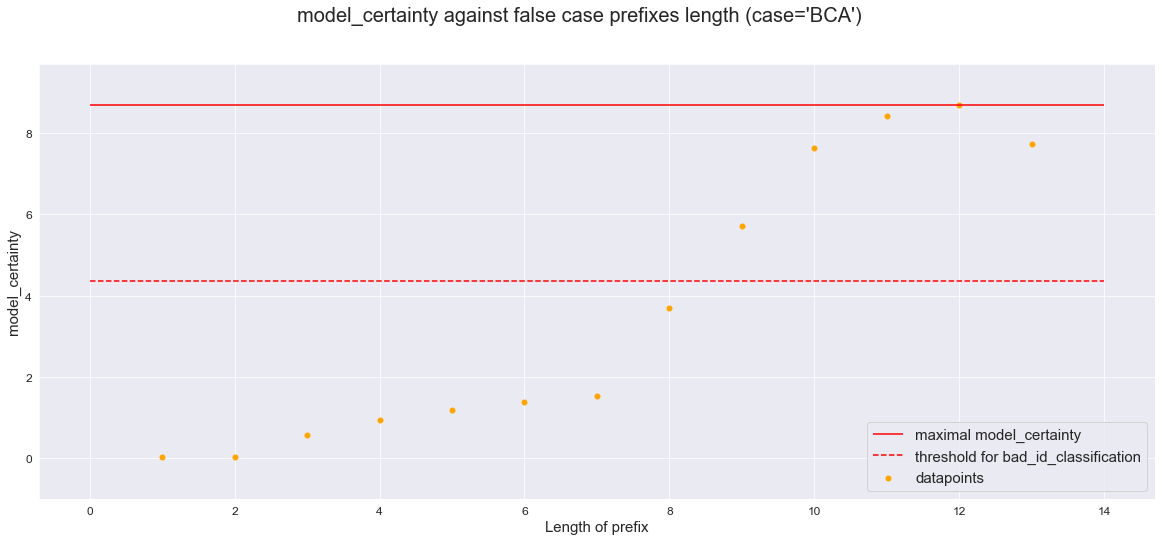

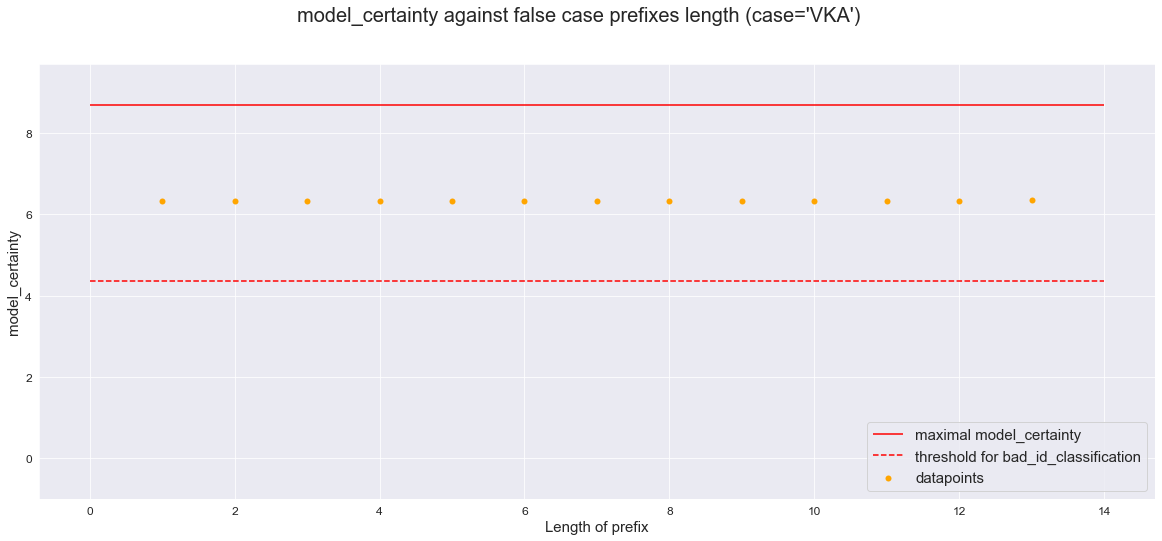

In [216]:
name = 'sepsis_cases_2'
_, df_targ = creation_and_prediction(name, determine_columns_sel(name))
fc_df, max = binning_of_ids(df_targ)
index_rel = get_bad_ids(fc_df, name)
are_bad_ids_prefixes(df_targ, index_rel, max, name)

In [218]:
# important event logs: ['sepsis_cases_2', 'production', 'bpic2011_f3']